In [1]:
import tensorflow as tf
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.))

In [2]:
shape = 200, 200
num_channels = 1
vec_size = 64

## Data utils

In [3]:
def load_dir(path, shape=[400, 400]):
    data = []
    for i in os.listdir(path):
        try:
            img = np.array(Image.open(os.path.join(path, i)).resize(shape))
            if len(img.shape) != 3:
                img = np.stack((img,)*3, -1)
            if img.shape[-1] != 3:
                continue
            data.append(img)
        except:
            1
    return np.array(data)

def load_dirs(path, shape=[400, 400]):
    data = []

    for dir in os.listdir(path):
        if os.path.isdir(os.path.join(path, dir)):
            data.extend(load_dir(os.path.join(path, dir)))

    data = np.array(data)
    
    return data

data = []

for dir in os.listdir('Animals/'):
    if os.path.isdir(os.path.join('Animals/', dir)):
        data.extend(load_dir(os.path.join('Animals/', dir), shape=shape))
    
data = np.array(data)

In [35]:
data=np.load('animals.npz')

In [36]:
data = data.mean(-1)

In [37]:
data = data.reshape([-1, shape[0], shape[1], 1])

In [38]:
data.shape

(7394, 200, 200, 1)

## VAE

In [4]:
x = tf.placeholder(dtype=tf.float32, shape=[None, shape[0], shape[1], num_channels])

### Encoder

In [21]:
def encoder(x):
    # Convolutions 

    conv = tf.layers.conv2d(x, 16, 4, activation=tf.nn.relu)
    pool = tf.layers.max_pooling2d(conv, 6, 1)

    conv = tf.layers.conv2d(pool, 32, 4, activation=tf.nn.relu)
    pool = tf.layers.max_pooling2d(conv, 8, 2)

    # Denses

    pool_shape = pool.shape

    flat_pool = tf.reshape(pool, [-1, (pool_shape[1]*pool_shape[2]*pool_shape[3]).value])

    dense = tf.layers.dense(flat_pool, 256, activation=tf.nn.relu)

    # Output

    gausian_params = tf.layers.dense(dense, vec_size*2)

    return gausian_params[:, :vec_size], 1e-16 + tf.nn.softplus(gausian_params[:, vec_size:])

In [22]:
with tf.variable_scope('encoder'):
    means, std_devs = encoder(x)

z = means + std_devs * tf.random_uniform(tf.shape(means), 0, 1, dtype=tf.float32)

## Decoder

In [23]:
input_z = tf.placeholder(tf.float32, shape=[None, vec_size])

In [24]:
decoder_weights = {
    'first_dense': tf.Variable(glorot_init(shape=[vec_size, 64]), dtype=tf.float32, name='first_dense'),
    'second_dense': tf.Variable(glorot_init(shape=[64, 128]), dtype=tf.float32, name='second_dense'),
    'third_dense': tf.Variable(glorot_init(shape=[128, 256]), dtype=tf.float32, name='third_dense'),
    'output': tf.Variable(glorot_init(shape=[128, shape[0]*shape[1]*num_channels]), dtype=tf.float32, name='output'),
}

decoder_biases = {
    'first_dense': tf.Variable(tf.zeros(64), dtype=tf.float32, name='first_dense'),
    'second_dense': tf.Variable(tf.zeros(128), dtype=tf.float32, name='second_dense'),
    'third_dense': tf.Variable(tf.zeros(128), dtype=tf.float32, name='third_dense'),
    'output': tf.Variable(tf.zeros(shape[0]*shape[1]*num_channels), name='output')
}

In [26]:
def decoder(z):
    
    dense = tf.nn.relu(tf.matmul(z, decoder_weights['first_dense']) + decoder_biases['first_dense'])
    
    dense = tf.nn.relu(tf.matmul(dense, decoder_weights['second_dense']) + decoder_biases['second_dense'])
        
    raw_output = tf.matmul(dense, decoder_weights['output']) + decoder_biases['output']
    
    raw_output = tf.clip_by_value(raw_output, 0, 255)
    
    return tf.reshape(raw_output, shape=[tf.shape(raw_output)[0], shape[0], shape[1], num_channels])

In [27]:
y = decoder(z)
output_decoder = decoder(input_z)

## Train Utils

In [28]:
marginal_likelihood = tf.reduce_sum(np.power(x - y, 2))
KL_divergence = 0.5 * tf.reduce_sum(tf.square(means) + tf.square(std_devs) - tf.log(1e-8 + tf.square(std_devs)) - 1, 1)

marginal_likelihood = tf.reduce_mean(marginal_likelihood)
KL_divergence = tf.reduce_mean(KL_divergence)

loss = marginal_likelihood + KL_divergence

In [29]:
optim = tf.train.AdamOptimizer().minimize(loss)

## Training

In [30]:
sess = tf.InteractiveSession()

In [31]:
sess.run(tf.global_variables_initializer())

In [32]:
save = tf.train.Saver()

In [18]:
import PIL

In [23]:
def display_encoded(ids):
    f, axar = plt.subplots(len(ids), 2, figsize=(8, 6))
    for e, i in enumerate(ids):
        axar[e, 0].grid(False); axar[e, 1].grid(False)
        axar[e, 0].imshow(PIL.Image.fromarray(data[i]))
        generated = sess.run(y, feed_dict={x: np.array([data[i]], dtype=np.float32)})
        axar[e, 1].imshow(PIL.Image.fromarray(generated[0].astype(np.uint8)))

In [ ]:
batchsize = 50
epochs = 500

for e in range(epochs):
    np.random.shuffle(data)
    print('Epoch: ', e)
    losses = []
    for i in range(0, len(data)-batchsize, batchsize):
        _, l = sess.run([optim, loss], feed_dict={x: data[i:i+batchsize]})
        losses.append(l)
        if i % 100 == 0:
            print('Loss: ', np.mean(losses))
            
    save.save(sess, 'new_weights/VAE_0'+str(e))
    print('Epoch loss: ', np.mean(losses))

In [83]:
i = 4000

In [84]:
a=sess.run(y, feed_dict={x: [data[i]]})

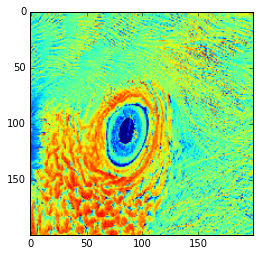

In [85]:
plt.imshow(data[i].reshape(200, 200))

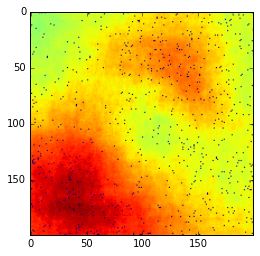

In [86]:
plt.imshow(a[0].reshape(200, 200))

### Test

In [22]:
i = 6000

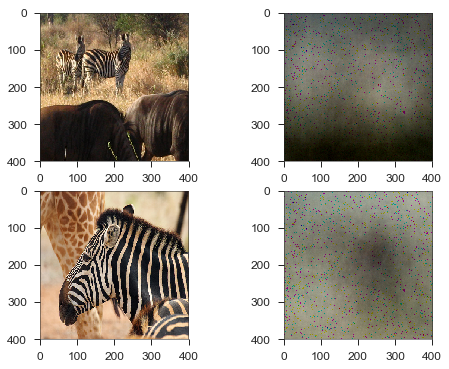

In [25]:
display_encoded([i, i+1])